In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mobility_data_manager import DataManager
from utils.common import load_data, Data


SELECTED_DATA= Data.SMALL

In [2]:
df = load_data(SELECTED_DATA)

In [3]:
# Ver las dimensiones del DataFrame (filas y columnas)
print(f"Dimensiones del DataFrame: {df.shape}")

# Ver los nombres de las columnas y sus tipos de datos
print("\nInformación del DataFrame:")
display(df.info())  # display() para mejor presentación en notebooks

# # Mostrar las primeras filas del DataFrame
# print("\nPrimeras filas del DataFrame:")

# # Resumen estadístico de los datos numéricos
print("\nResumen estadístico:")
display(df.describe())

Dimensiones del DataFrame: (8265, 5)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8265 entries, 0 to 8264
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   uid     8265 non-null   int64
 1   d       8265 non-null   int64
 2   t       8265 non-null   int64
 3   x       8265 non-null   int64
 4   y       8265 non-null   int64
dtypes: int64(5)
memory usage: 323.0 KB


None


Resumen estadístico:


,uid,d,t,x,y
count,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000
mean,2.041742,37.479371,25.221779,106.090986,86.803388
std,1.445300,21.550568,11.881415,31.766607,20.436812
min,0.000000,0.000000,0.000000,46.000000,1.000000
25%,1.000000,19.000000,17.000000,77.000000,77.000000
50%,2.000000,38.000000,25.000000,97.000000,84.000000
75%,4.000000,57.000000,35.000000,137.000000,99.000000
max,4.000000,74.000000,47.000000,182.000000,144.000000


In [4]:
def split_data(df):
    """
    Divide los datos en entrenamiento, validación y prueba según el rango de días.
    """
    train = df[df["d"] < 44]  # Días antes de validación
    val = df[
        (df["d"] >= 29) & (df["d"] < 59)
    ]  # Incluye días de entrada y target para validación
    test = df[(df["d"] >= 44)]  # Incluye días de entrada y target para prueba
    return train, val, test


train_df, val_df, test_df = split_data(df)
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

In [5]:
def collate_fn(batch):
    """
    Aplica padding a un lote de datos para igualar la longitud de las secuencias.
    Usa -1 como valor de padding.
    """
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:  # Si todo el batch vacío
        return None

    sequences, targets, masks, user_ids = zip(*batch)
    batch = [item for item in sequences if not item.nelement() == 0]
    if len(batch) == 0:  # Si todo el lote de sequencesestá vacío
        return None

    # Aplicar padding a las secuencias y targets
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=-1.0)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=-1.0)
    padded_masks = pad_sequence(
        masks, batch_first=True, padding_value=0.0
    )  # Máscara: padding = 0

    # Convertir user_ids a tensor
    user_ids = torch.stack(user_ids)

    return padded_sequences, padded_targets, padded_masks, user_ids


def normalize_data(data):
    """
    Normaliza las columnas ['x', 'y', 't', 'd', 't_unificado'] en el rango [0, 1].
    """
    scaler = MinMaxScaler()

    # Crear 't_unificado' si no existe
    if "t_unificado" not in data.columns:
        data["t_unificado"] = data["d"] * 48 + data["t"]

    # Seleccionar columnas para normalizar
    columns_to_normalize = ["x", "y", "t_unificado"]
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

    return data, scaler


def generate_sequences(data, window_size=15):
    sequences = []
    targets = []
    masks = []
    user_ids = []

    for user_id, group in data.groupby("uid"):
        group = group.sort_values(by="t_unificado").reset_index(drop=True)

        num_max_days = group["d"].max() + 1
        num_min_days = group["d"].min()
        num_days = num_max_days - num_min_days

        if num_days < 2 * window_size:
            continue

        for start_day in range(0, num_days - 2 * window_size + 1):
            start_day += num_min_days
            input_data = group[
                (group["d"] >= start_day) & (group["d"] < start_day + window_size)
            ][["x", "y", "t_unificado"]].values

            target_data = group[
                (group["d"] >= start_day + window_size)
                & (group["d"] < start_day + 2 * window_size)
            ][["x", "y", "t_unificado"]].values

            # Crear una máscara: 1 para valores válidos, 0 para posiciones sin datos
            mask = [1] * len(target_data) + [0] * (15 * 48 - len(target_data))

            # Rellenar con ceros si el target es más corto
            if len(target_data) < 15 * 48:
                padding = [[0, 0, 0]] * (15 * 48 - len(target_data))
                target_data = np.vstack([target_data, padding])

            sequences.append(input_data)
            targets.append(target_data)
            masks.append(mask)
            user_ids.append(user_id)

    return sequences, targets, masks, user_ids

In [6]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


In [7]:
class LSTMDataset(Dataset):
    def __init__(self, sequences, targets, masks, user_ids):
        """
        sequences: Lista de secuencias de entrada.
        targets: Lista de targets.
        masks: Lista de máscaras que indican valores válidos en los targets.
        user_ids: Lista de IDs de usuarios.
        """
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
        self.targets = [torch.tensor(target, dtype=torch.float32) for target in targets]
        self.masks = [torch.tensor(mask, dtype=torch.float32) for mask in masks]
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.sequences[idx].nelement() == 0:  # Verifica si el tensor está vacío
            return None
        return (
            self.sequences[idx],
            self.targets[idx],
            self.masks[idx],
            self.user_ids[idx],
        )

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=2, target_steps=15 * 48):
        super(LSTMModel, self).__init__()

        # LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )

        # Capa de salida para predecir (x, y, t_unificado) para los próximos 15 días
        self.fc_output = nn.Linear(hidden_dim, target_steps * 3)

    def forward(self, x, lengths):
        """
        x: Tensor de entrada (batch_size, seq_len, input_dim)
        lengths: Longitudes reales de las secuencias (sin padding)
        """
        # Crear una máscara para ignorar el padding (-1)
        mask = x[:, :, 0] != -1  # Elige cualquier canal para verificar el padding

        # Reemplazar valores de padding con ceros
        x = torch.where(mask.unsqueeze(-1), x, torch.tensor(0.0, device=x.device))

        # Empaquetar las secuencias para ignorar el padding
        packed_x = pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        packed_output, _ = self.lstm(packed_x)

        # Desempaquetar las secuencias
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Tomar la última salida válida según la longitud real
        last_hidden_state = lstm_out[
            range(len(lengths)), lengths - 1, :
        ]  # Última salida válida

        # Pasar por la capa completamente conectada para predecir los próximos 15 días
        output = self.fc_output(last_hidden_state)

        # Reshape a (batch_size, 15 * 48, 3)
        output = output.reshape(-1, 15 * 48, 3)

        return output

In [9]:
# Normalizar los datos
BATCH_SIZE = 64
train_df, train_scaler = normalize_data(train_df)
val_df, val_scaler = normalize_data(val_df)
test_df, test_scaler = normalize_data(test_df)

# Generar secuencias
train_sequences, train_targets, train_mask, train_user_ids = generate_sequences(
    train_df
)
val_sequences, val_targets, val_mask, val_user_ids = generate_sequences(val_df)
test_sequences, test_targets, test_mask, test_user_ids = generate_sequences(test_df)

# Crear datasets
train_dataset = LSTMDataset(train_sequences, train_targets, train_mask, train_user_ids)
val_dataset = LSTMDataset(val_sequences, val_targets, val_mask, val_user_ids)
test_dataset = LSTMDataset(test_sequences, test_targets, test_mask, test_user_ids)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

Epoch 1/2, Training Loss: 1.1630
Epoch 1/2, Validation Loss: 1.0590
Nuevo mejor modelo guardado en la época 1 con pérdida: 1.0590
Epoch 2/2, Training Loss: 1.1169
Epoch 2/2, Validation Loss: 1.0042
Nuevo mejor modelo guardado en la época 2 con pérdida: 1.0042
Modelo cargado con la mejor pérdida de validación: 1.0042


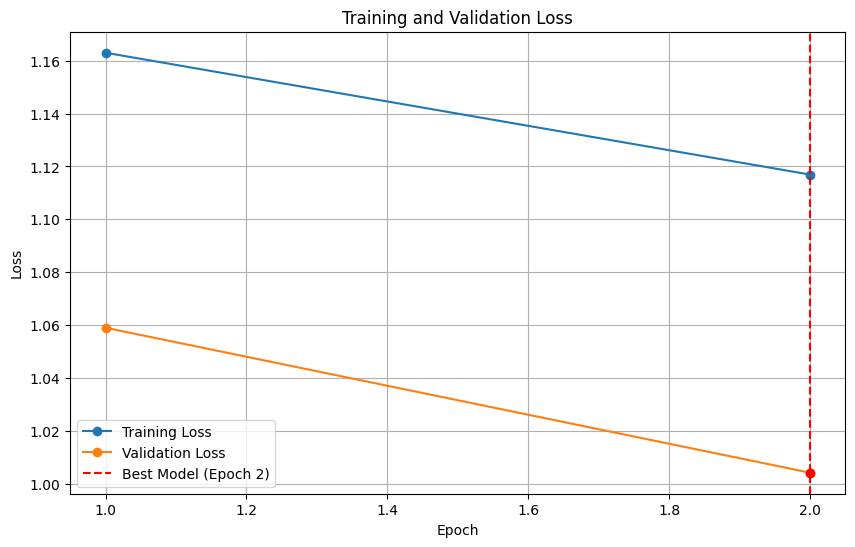

In [10]:
import matplotlib.pyplot as plt


def masked_loss_function(preds, targets, masks):
    """
    Calcula la pérdida MSE ignorando los valores marcados como padding (máscara=0).
    """
    loss = (preds - targets) ** 2  # Error cuadrático
    masked_loss = loss * masks.unsqueeze(-1)  # Aplicar la máscara
    return masked_loss.sum() / masks.sum()  # Normalizar por los valores válidos


num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=3, hidden_dim=128, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float("inf")
best_model_state = None  # Para almacenar el mejor modelo
best_epoch = -1  # Para guardar la época con el mejor modelo

# Listas para guardar las pérdidas de entrenamiento y validación
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        sequence_batch, target_batch, mask_batch, user_id_batch = batch

        # Calcular longitudes reales de las secuencias
        lengths = (sequence_batch[:, :, 0] != -1).sum(dim=1)

        # Pasar los datos al dispositivo
        sequence_batch = sequence_batch.to(device)
        target_batch = target_batch.to(device)
        mask_batch = mask_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(sequence_batch, lengths)

        # Calcular la pérdida usando las máscaras
        loss = masked_loss_function(outputs, target_batch, mask_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Guardar la pérdida de entrenamiento
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # Validación dentro de la época
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:  # Si el lote está vacío, saltar
                continue
            sequence_batch, target_batch, mask_batch, user_id_batch = batch

            # Calcular longitudes reales de las secuencias
            lengths = (sequence_batch[:, :, 0] != -1).sum(dim=1)

            # Pasar los datos al dispositivo
            sequence_batch = sequence_batch.to(device)
            target_batch = target_batch.to(device)
            mask_batch = mask_batch.to(device)

            # Forward pass
            outputs = model(sequence_batch, lengths)

            # Calcular la pérdida usando las máscaras
            loss = masked_loss_function(outputs, target_batch, mask_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Guardar la pérdida de validación
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        best_epoch = epoch + 1  # Guardar la época del mejor modelo
        print(
            f"Nuevo mejor modelo guardado en la época {best_epoch} con pérdida: {best_val_loss:.4f}"
        )

# Cargar el mejor modelo después del entrenamiento
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Modelo cargado con la mejor pérdida de validación: {best_val_loss:.4f}")

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o")

# Marcar el mejor modelo
plt.axvline(
    best_epoch, color="r", linestyle="--", label=f"Best Model (Epoch {best_epoch})"
)
plt.scatter(best_epoch, best_val_loss, color="red", zorder=5)

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [11]:
torch.save(model, "../Data/Models/LSTM_NN.pth")
print("Modelo completo guardado correctamente en 'LSTM_NN.pth'.")

Modelo completo guardado correctamente en 'LSTM_NN.pth'.


In [12]:
model.eval()
val_loss = 0
with torch.no_grad():
    for batch in val_loader:
        if batch is None:  # Si el lote está vacío, saltar
            continue

        sequence_batch, target_batch, mask_batch, user_id_batch = batch

        # Calcular longitudes reales de las secuencias
        lengths = (sequence_batch[:, :, 0] != -1).sum(dim=1)

        # Pasar los datos al dispositivo
        sequence_batch = sequence_batch.to(device)
        target_batch = target_batch.to(device)
        mask_batch = mask_batch.to(device)

        # Forward pass
        outputs = model(sequence_batch, lengths)

        # Calcular la pérdida usando las máscaras
        loss = masked_loss_function(outputs, target_batch, mask_batch)
        val_loss += loss.item()

print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

Validation Loss: 1.0042


In [13]:
model.eval()
test_loss = 0
user_data = {}  # Diccionario para almacenar predicciones y objetivos por usuario

with torch.no_grad():
    for batch in test_loader:
        if batch is None:  # Si el lote está vacío, saltar
            continue
        sequence_batch, target_batch, mask_batch, user_id_batch = batch

        # Calcular longitudes reales de las secuencias
        lengths = (sequence_batch[:, :, 0] != -1).sum(dim=1)

        # Pasar los datos al dispositivo
        sequence_batch = sequence_batch.to(device)
        target_batch = target_batch.to(device)
        mask_batch = mask_batch.to(device)
        user_id_batch = user_id_batch.to(device)

        # Forward pass
        preds = model(sequence_batch, lengths)

        # Calcular la pérdida usando las máscaras
        loss = masked_loss_function(preds, target_batch, mask_batch)
        test_loss += loss.item()

        for i, user_id in enumerate(user_id_batch.cpu().numpy()):
            if user_id not in user_data:
                user_data[user_id] = {"preds": [], "targets": []}
            user_data[user_id]["preds"].append(preds[i].cpu().numpy())
            user_data[user_id]["targets"].append(target_batch[i].cpu().numpy())

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# Concatenar los datos para cada usuario
for user_id in user_data:
    user_data[user_id]["preds"] = np.concatenate(user_data[user_id]["preds"], axis=0)
    user_data[user_id]["targets"] = np.concatenate(
        user_data[user_id]["targets"], axis=0
    )

Test Loss: 1.1157


In [14]:
def process_data_by_day_aligned(user_preds, user_targets, scaler, timesteps_per_day=48):
    """
    Procesa los datos de predicciones y objetivos por día, alineándolos por `t_unified`,
    utilizando directamente los índices en las predicciones basados en los días y timeslots.

    Args:
        user_preds: Predicciones del modelo para un usuario (array de shape [Días * 48, 3]).
        user_targets: Objetivos reales para un usuario (array de shape [N, 3]).
        scaler: Escalador para desnormalizar los datos.
        timesteps_per_day: Cantidad de pings en un día.

    Returns:
        aligned_data: Diccionario donde las claves son los días y los valores son tuplas
                      con listas de objetivos y predicciones alineadas.
    """
    aligned_data = {}

    # Desnormalizar los objetivos (los predichos no se tocan en la columna 2)
    user_targets = scaler.inverse_transform(user_targets)
    user_preds = scaler.inverse_transform(user_preds)
    min_day = int(user_targets[:, 2].min())
    min_day //= timesteps_per_day

    for target in user_targets:
        t_unified = target[2]  # Obtener el t_unified del target
        day = int(t_unified // timesteps_per_day)  # Día del target
        timeslot = int(t_unified % timesteps_per_day)  # Timeslot del target

        # Calcular el índice de la predicción correspondiente
        pred_index = (day - min_day) * timesteps_per_day + timeslot

        # Verificar que el índice esté dentro del rango de las predicciones
        if 0 <= pred_index < len(user_preds):
            pred = user_preds[pred_index]

            if day not in aligned_data:
                aligned_data[day] = ([], [])  # Inicializar listas para el día

            # Agregar objetivo y predicción alineados
            aligned_data[day][0].append(target[:2])  # x, y del target
            aligned_data[day][1].append(pred[:2])  # x, y de la predicción

    # Convertir listas a numpy arrays
    for day in aligned_data:
        aligned_data[day] = (
            np.array(aligned_data[day][0]),
            np.array(aligned_data[day][1]),
        )

    return aligned_data


def plot_user_trajectories_aligned(
    user_id, user_data, num_days, scaler, timesteps_per_day=48
):
    """
    Grafica las trayectorias alineadas por día para un usuario específico.

    Args:
        user_id: ID del usuario.
        user_data: Diccionario con los datos de predicciones y objetivos por usuario.
        num_days: Número de días a graficar.
        scaler: Escalador para desnormalizar los datos.
        timesteps_per_day: Cantidad de pings en un día.
    """
    if user_id not in user_data:
        print(f"No hay datos disponibles para el usuario {user_id}.")
        return

    # Obtener predicciones y objetivos para el usuario
    user_preds = user_data[user_id]["preds"]
    user_targets = user_data[user_id]["targets"]
    user_targets = user_targets[
        ~np.all(user_targets == 0, axis=1)
    ]  # Eliminar filas con ceros

    # Procesar datos alineados por día
    data = process_data_by_day_aligned(
        user_preds=user_preds,
        user_targets=user_targets,
        scaler=scaler,
        timesteps_per_day=timesteps_per_day,
    )

    # Configurar la cuadrícula de gráficos
    cols = 5
    rows = (num_days + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
    axes = axes.flatten()

    # Graficar los datos alineados por día
    days = sorted(data.keys())
    for i, day in enumerate(days[:num_days]):
        targets, preds = data[day]

        # Asegurarse de que hay datos para graficar
        if targets.size == 0 or preds.size == 0:
            continue

        x_targets, y_targets = targets[:, 0], targets[:, 1]
        x_preds, y_preds = preds[:, 0], preds[:, 1]

        ax = axes[i]
        ax.grid(color="gray", linestyle="--", linewidth=0.5)
        ax.plot(
            x_targets, y_targets, label="Real", marker="o", color="blue", markersize=4
        )
        ax.plot(
            x_preds, y_preds, label="Predicho", marker="x", color="orange", markersize=4
        )
        ax.set_title(f"Usuario {user_id}, Día {day}")
        ax.set_xlabel("Coordenada X")
        ax.set_ylabel("Coordenada Y")
        ax.legend()

    # Eliminar ejes vacíos si sobran espacios
    for j in range(len(days[:num_days]), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

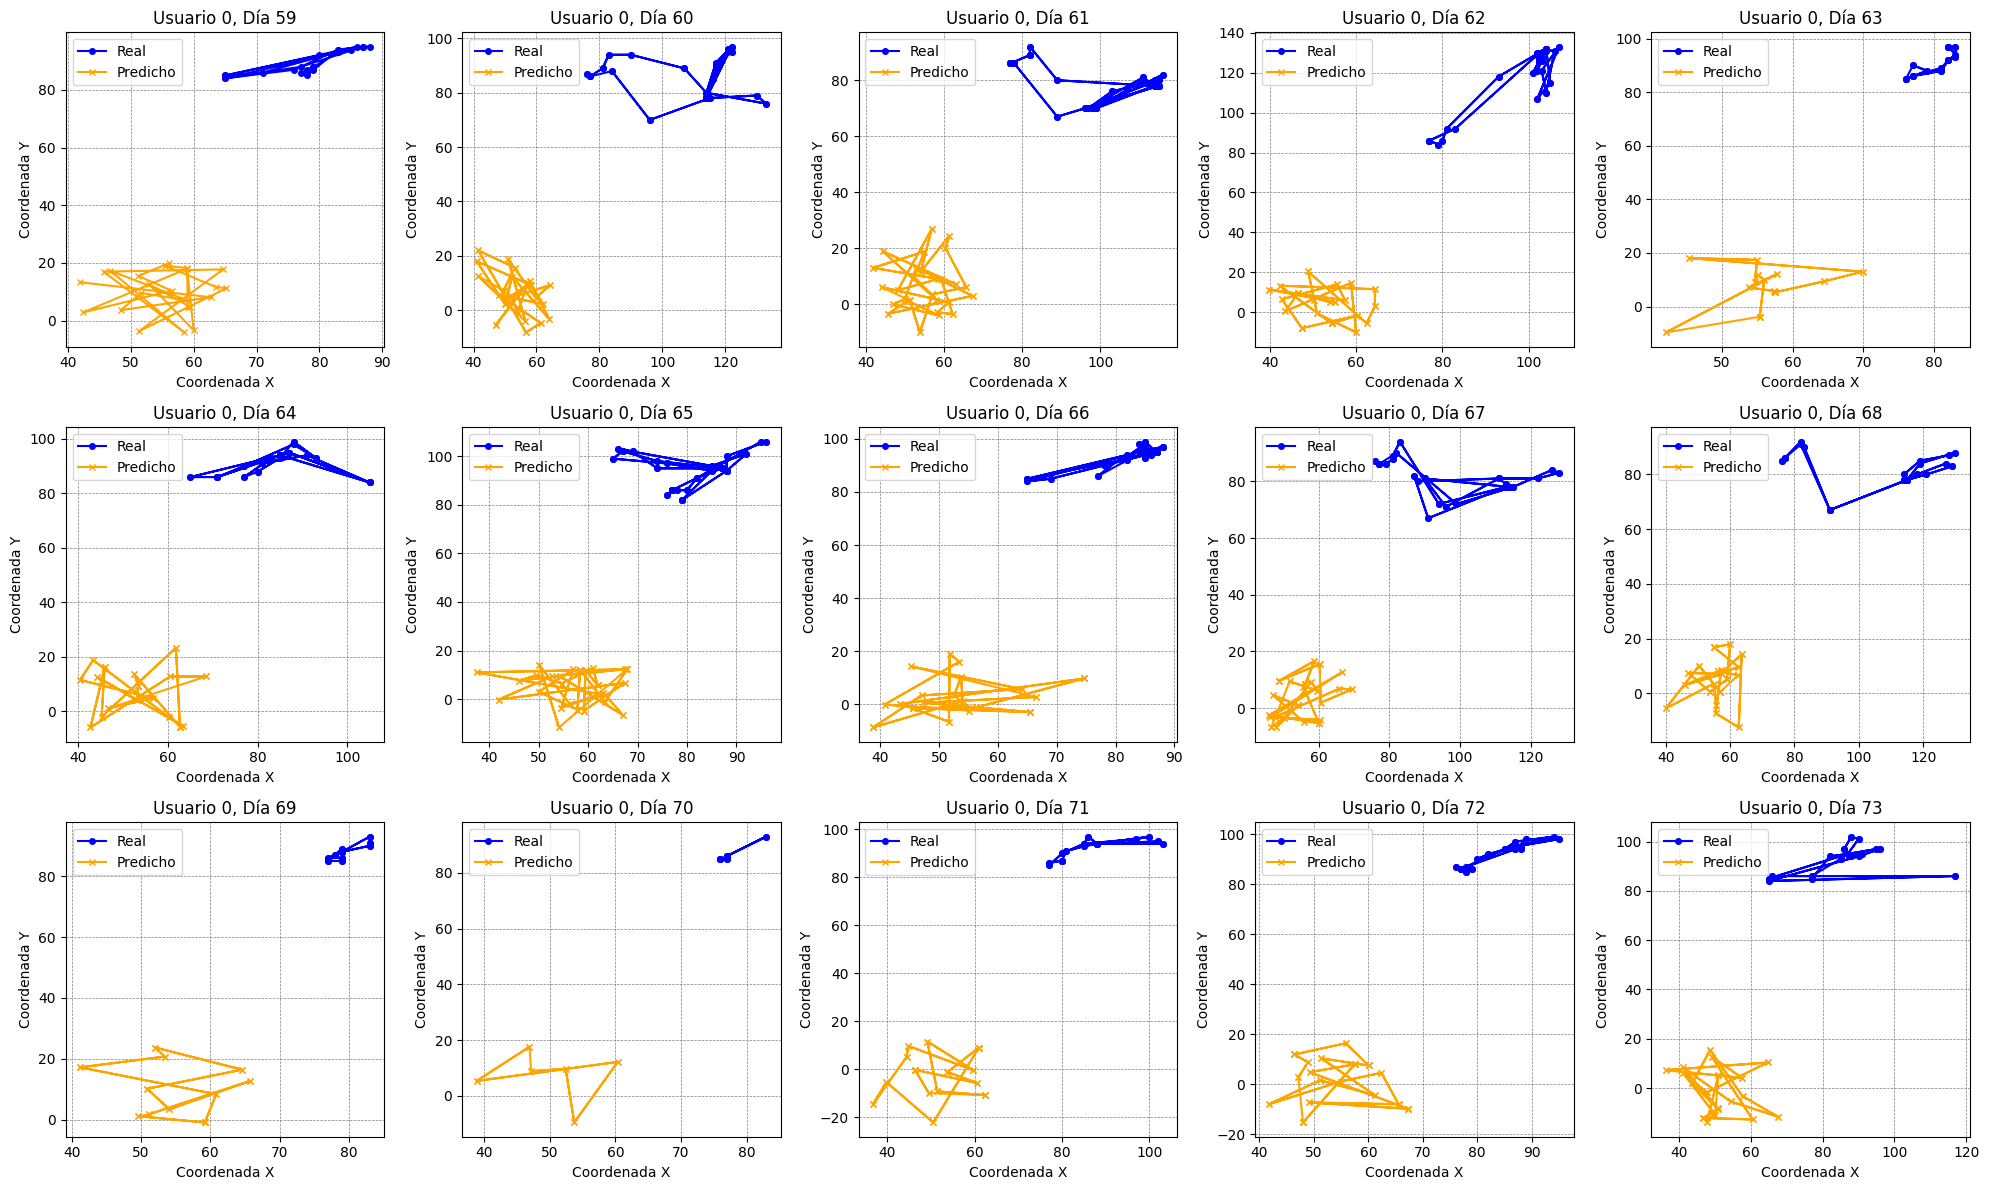

In [15]:
# Graficar las trayectorias alineadas para un usuario
plot_user_trajectories_aligned(
    user_id=0,
    user_data=user_data,
    scaler=test_scaler,
    num_days=15,
)

In [16]:
def calculate_metrics(y_true, y_pred):
    """
    Calcula varias métricas de evaluación para predicciones en problemas de regresión.

    :param y_true: Array de valores reales. Shape: (n_samples, n_features)
    :param y_pred: Array de valores predichos. Shape: (n_samples, n_features)
    :return: Diccionario con métricas calculadas.
    """
    # Asegurarse de que las entradas son numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Validar que las formas coincidan
    if y_true.shape != y_pred.shape:
        raise ValueError("Las dimensiones de y_true y y_pred no coinciden.")

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # R² Score
    r2 = r2_score(y_true, y_pred)

    # Distancia Euclidiana Promedio (para coordenadas x, y)
    if y_true.shape[1] == 2:  # Solo si hay coordenadas en 2D
        euclidean_distances = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))
        avg_euclidean_distance = np.mean(euclidean_distances)
    else:
        avg_euclidean_distance = None

    # Devuelve las métricas en un diccionario
    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "Avg_Euclidean_Distance": avg_euclidean_distance,
    }
    return metrics